
# Transformer Preprocessing & Embedding Visualization

This notebook explores preprocessing techniques used to prepare raw text for Transformer-based models. It focuses on the positional encoding mechanisms and how they interact with word embeddings prior to being passed into the encoder and decoder components.

### Objectives

- Visualize sinusoidal positional encodings and understand their mathematical structure
- Explore how positional information alters the behavior of word embeddings
- Build intuition around sequence-aware input representations in Transformers

<a name='0'></a>
## Package Imports

The following packages are required to support visualization, matrix computation, and model-related operations.
```

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

<a name='1'></a>
## 1. Positional Encoding

Transformers rely on positional encodings to inject information about token order into word embeddings. This is essential because, unlike RNNs, Transformers do not process sequences sequentially — they process all tokens in parallel. To compensate, positional encodings are added to the embeddings before they enter the encoder or decoder.

The standard sinusoidal positional encoding formula is defined as:

$$
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{d}}}\right)
$$

$$
PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{d}}}\right)
$$

Where:
- $pos$ is the position in the sequence
- $i$ is the dimension index
- $d$ is the total dimension of the embedding

---

In natural language processing tasks, text is first tokenized, then mapped to fixed-size numerical vectors called embeddings. These embeddings represent semantic meaning, but on their own, they do not carry information about word order.

To address this, positional encodings are added to the embeddings so that the model can distinguish between tokens based not only on meaning but also on position. 

Although these encodings are mathematical in nature, visualization provides useful insight. For example:
- Embeddings for semantically similar words tend to appear closer together in 2D space.
- Similarly, positional encoding vectors for nearby tokens in a sentence should also exhibit proximity when visualized.

This section introduces visualizations to help better understand how positional encodings behave and how they influence the embedding space in a Transformer model.


### Visualizing Positional Encodings

The function provided below computes positional encodings. It will be used in subsequent visualizations to explore how these encodings evolve across token positions and embedding dimensions.


In [2]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """

    # initialize a matrix angle_rads of all the angles 
    angle_rads = np.arange(positions)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d)[np.newaxis, :]//2)) / np.float32(d))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

For this experiment, we define an embedding dimension of 100, which corresponds to the dimensionality of the word embeddings used throughout the Transformer model. This value should match the size of both the learned token embeddings and the positional encoding vectors.

In the original [“Attention Is All You Need”](https://arxiv.org/abs/1706.03762) paper, embedding sizes vary from 100 to 1024 depending on the complexity of the task. Similarly, the maximum sequence length varies between 40 and 512 tokens.

For the purpose of visualization and analysis here, we’ll use:
- **Maximum sequence length** = 100  
- **Maximum number of tokens to visualize** = 64  

These values allow us to effectively observe the structure of positional encodings without excessive computational overhead.


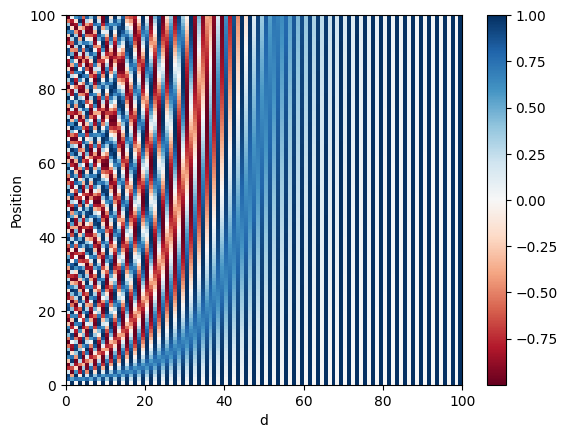

In [3]:
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 64
pos_encoding = positional_encoding(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, EMBEDDING_DIM))
plt.ylabel('Position')
plt.colorbar()
plt.show()

Let’s examine the positional encoding matrix more closely. One interesting property is that the **norm of each positional encoding vector remains constant**, regardless of its position in the sequence.

For example, in this setup, the norm of each vector is approximately **7.071068**, independent of the position index `pos`. This consistency arises from the sinusoidal structure of the encoding formula.

As a result, the **scale of the vectors does not vary with position**, which means that operations like dot products or cosine similarity between different positional encodings are influenced purely by direction rather than magnitude.

This has important implications:
- Correlation between encodings is **not affected by vector length**
- Positional differences are encoded through **angular relationships**, not scale

This property is particularly beneficial for the attention mechanism, where alignment is computed via dot products between input representations.


In [4]:
pos = 34
tf.norm(pos_encoding[0,pos,:])

<tf.Tensor: shape=(), dtype=float32, numpy=7.0710673332214355>

Another noteworthy property of sinusoidal positional encodings is that the **norm of the difference between two encoding vectors remains approximately constant when the positional gap `k` is fixed**.

In other words, for any constant offset `k`, the norm of the difference between `PE(pos)` and `PE(pos + k)` remains nearly the same, regardless of the actual value of `pos`.

This behavior reflects the fact that **the encodings capture relative position**, not just absolute position. The difference between two encodings is determined by how far apart the tokens are in the sequence — not where they occur.

This property is useful for learning:
- It enables the model to focus on **relative distances between tokens**
- It supports the model’s ability to generalize across varying input lengths and positions
- It allows for consistent interpretation of local structure

Importantly, this behavior is achieved while keeping the encoded vector values bounded (e.g., between -1 and 1), ensuring that **positional information enhances rather than distorts the semantic content of the word embeddings**.


In [5]:
pos = 70
k = 2
print(tf.norm(pos_encoding[0,pos,:] -  pos_encoding[0,pos + k,:]))

tf.Tensor(3.2668781, shape=(), dtype=float32)



### Comparing Positional Encodings

#### Correlation Analysis

The positional encoding matrix assigns a unique vector to each position in a sequence. One way to evaluate how effectively these vectors capture position is to analyze their **pairwise correlations**.

By computing the correlation between every pair of positional encoding vectors, we can observe how similar the encodings are across the sequence.

An effective positional encoding scheme should produce a **symmetric correlation matrix** with the highest values along the diagonal — where each position is most similar to itself. As the distance between positions increases, the correlation should gradually decrease, reflecting diminishing similarity between farther-apart tokens.

This structure supports the idea that:
- Tokens close together in a sequence are more positionally related
- Positional encoding preserves proximity relationships in the vector space


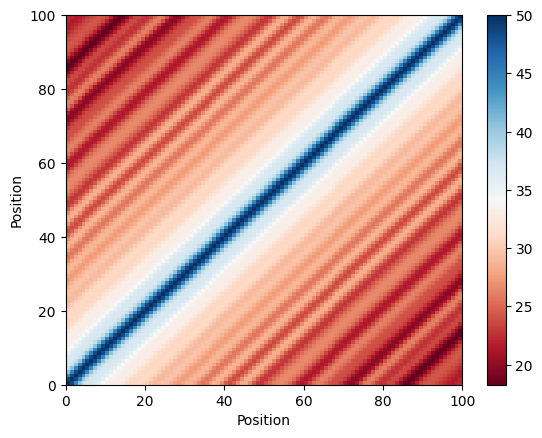

In [6]:
# Positional encoding correlation
corr = tf.matmul(pos_encoding, pos_encoding, transpose_b=True).numpy()[0]
plt.pcolormesh(corr, cmap='RdBu')
plt.xlabel('Position')
plt.xlim((0, MAX_SEQUENCE_LENGTH))
plt.ylabel('Position')
plt.colorbar()
plt.show()

#### Euclidean Distance

In addition to correlation, **Euclidean distance** can be used to measure similarity between positional encoding vectors.

When using Euclidean distance, the resulting visualization should produce a matrix where:
- The **main diagonal** contains zeros, since the distance between a vector and itself is zero.
- **Off-diagonal values** increase as the positional difference between vectors increases.

This pattern reinforces the idea that positional encodings vary progressively with distance, and that **tokens farther apart in the sequence are more distinct in encoding space**. Unlike correlation, which captures directional similarity, Euclidean distance emphasizes **absolute differences** in the encoding vectors.


(100, 100)


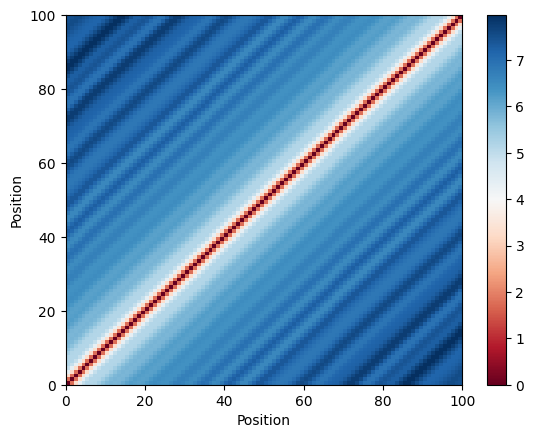

In [7]:
# Positional encoding euclidean distance
eu = np.zeros((MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH))
print(eu.shape)
for a in range(MAX_SEQUENCE_LENGTH):
    for b in range(a + 1, MAX_SEQUENCE_LENGTH):
        eu[a, b] = tf.norm(tf.math.subtract(pos_encoding[0, a], pos_encoding[0, b]))
        eu[b, a] = eu[a, b]
        
plt.pcolormesh(eu, cmap='RdBu')
plt.xlabel('Position')
plt.xlim((0, MAX_SEQUENCE_LENGTH))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 2. Semantic Embeddings and Positional Encoding

Previous visualizations highlighted how positional encoding vectors vary with position and relate to one another. In practice, these encodings are not used in isolation — they are **added to semantic word embeddings** to form the final input to a Transformer model.

This section explores how combining positional encodings with pretrained word embeddings alters the overall representation of input tokens, and what this implies for how the model encodes both **meaning** and **position**.

### Loading Pretrained Word Embeddings

To analyze this interaction, we first load a pretrained embedding matrix from the [GloVe project](https://nlp.stanford.edu/projects/glove/). These embeddings are trained on large corpora and capture semantic relationships between words in vector space.

For this experiment, we’ll use the version with **100-dimensional embeddings**, which matches the positional encoding dimension defined earlier.


In [9]:
embeddings_index = {}
GLOVE_DIR = "C:/Users/mattg/Downloads/Transformers_project/data/glove"
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
print('d_model:', embeddings_index['hi'].shape)

Found 400000 word vectors.
d_model: (100,)


**Note:** The GloVe embedding used here includes 400,000 words, with each word represented by a 100-dimensional vector.

To illustrate how positional encodings interact with semantic embeddings, we’ll use a toy example containing two artificial sentences. These sentences were designed not for meaning, but to highlight how **semantic structure and word order** affect the combined representations:

- In **Sentence 1**, semantically related words appear in consecutive groups.
- In **Sentence 2**, the same words are present but shuffled into a random order.

By comparing the resulting vector representations, we can observe how positional encoding influences spatial relationships in the embedding space.


In [10]:
texts = ['king queen man woman dog wolf football basketball red green yellow',
         'man queen yellow basketball green dog  woman football  king red wolf']

The next step applies basic tokenization to convert raw text into a numerical format suitable for input into a model.

This process includes:

- **Token indexing**: Each word in the text is mapped to a unique integer based on a vocabulary dictionary (`word_index`).
- **Sequence formatting**: Each sentence is transformed into a fixed-length array of indices, defined by `MAX_SEQUENCE_LENGTH`.
- **Padding**: Sentences shorter than the maximum length are padded with zeros to ensure a consistent shape across all inputs.

The result is a 2D matrix where each row represents a tokenized sentence of uniform length.


In [11]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

print(data.shape)

print(data)

Found 11 unique tokens.
(2, 100)
[[ 1  2  3  4  5  6  7  8  9 10 11  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 3  2 11  8 10  5  4  7  1  9  6  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]


To simplify the visualization, we extract only the embeddings for the specific words that appear in the toy sentences. In total, 11 unique words are used across both sentences.

A special token is also included at the beginning to represent unknown or out-of-vocabulary words. This token is encoded as a zero vector and serves as a placeholder during padding or in cases where a word does not appear in the vocabulary.


In [12]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(12, 100)


An embedding layer is initialized using the weights extracted from the pretrained GloVe embeddings. These weights are loaded into the layer to map token indices to their corresponding pretrained word vectors.


In [13]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            trainable=False)

The tokenized input is passed through the embedding layer to generate the corresponding word vectors for each token. The resulting output is a 3D tensor, where:

- The first dimension corresponds to the number of sentences
- The second dimension corresponds to the maximum sequence length
- The third dimension holds the embedding vector for each token

Inspecting the shape of this tensor confirms that each token is now represented by a fixed-length embedding.


In [14]:
embedding = embedding_layer(data)
print(embedding.shape)

(2, 100, 100)


### Embedding Visualization in 2D

To explore how word embeddings are spatially arranged, we use **Principal Component Analysis (PCA)** to reduce the 100-dimensional GloVe embeddings to two dimensions.

This reduction allows the encoded word vectors to be visualized on a 2D Cartesian plane, making it easier to interpret their relative semantic positions. Words with similar meanings or contextual usage are expected to cluster together in the projected space.


In [16]:
from sklearn.decomposition import PCA

def plot_words(embedding, sequences, sentence):
    pca = PCA(n_components=2)
    X_pca_train = pca.fit_transform(embedding[sentence,0:len(sequences[sentence]),:])


    fig, ax = plt.subplots(figsize=(12, 6)) 
    plt.rcParams['font.size'] = '12'
    ax.scatter(X_pca_train[:, 0], X_pca_train[:, 1])
    words = list(word_index.keys())
    for i, index in enumerate(sequences[sentence]):
        ax.annotate(words[index-1], (X_pca_train[i, 0], X_pca_train[i, 1]))


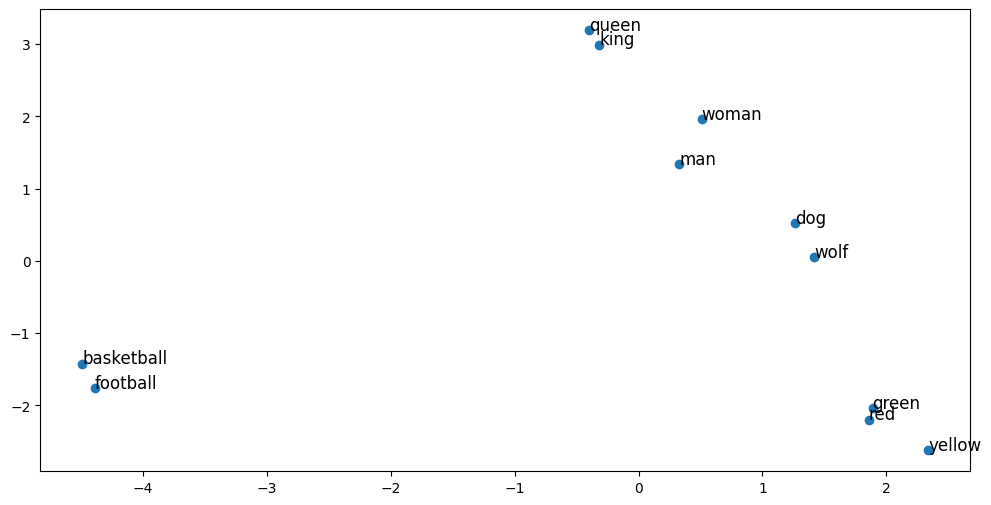

In [17]:
plot_words(embedding, sequences, 0)

The word embeddings for the second sentence are plotted below. This sentence contains the same set of words as the first, but arranged in a different order.

Since no positional encoding has been applied yet, the visualization confirms that **word order does not influence the embeddings**. The vectors are identical regardless of their position in the sentence, highlighting that semantic embeddings alone are not position-aware.


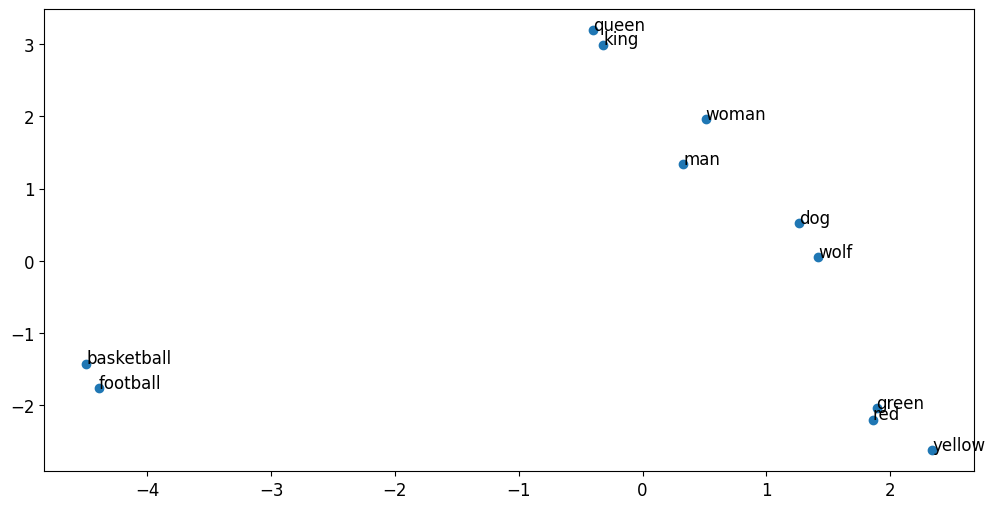

In [18]:
plot_words(embedding, sequences, 1)

## 3. Combining Semantic and Positional Embeddings

In this section, the original GloVe word embeddings are combined with the sinusoidal positional encodings calculated earlier.

A 1:1 weighting is applied, treating both semantic content and positional information as equally important in the resulting representation. This merged embedding is then used to examine how positional encodings influence the spatial distribution of otherwise order-invariant word vectors.


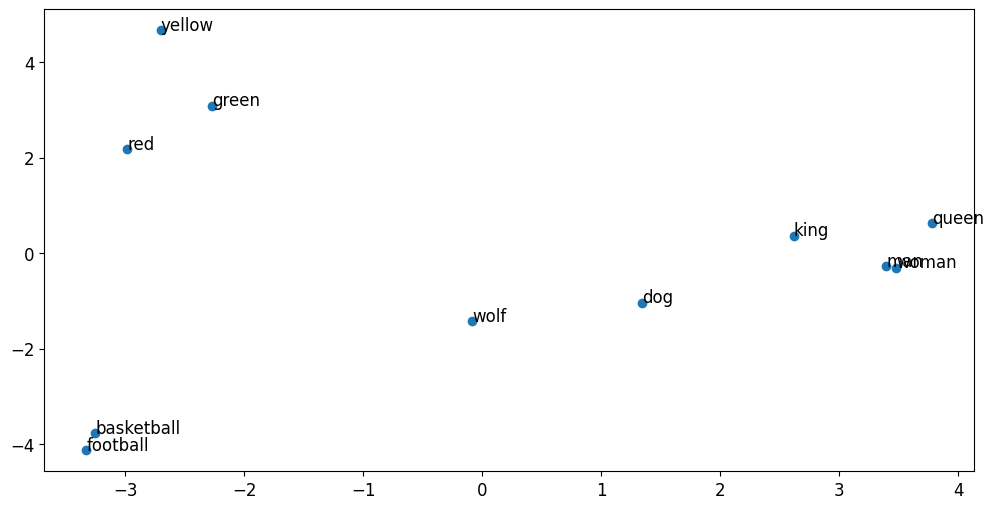

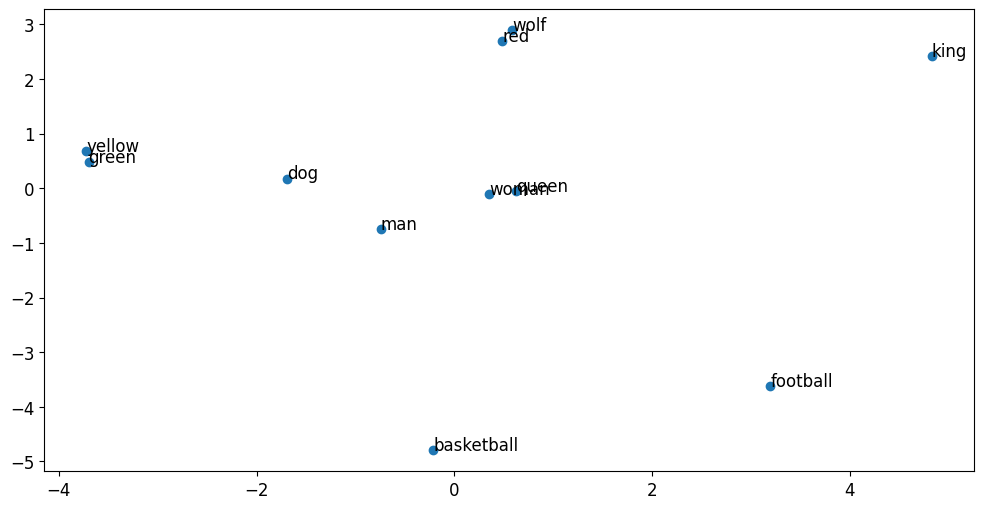

In [19]:
embedding2 = embedding * 1.0 + pos_encoding[:,:,:] * 1.0
plot_words(embedding2, sequences, 0)
plot_words(embedding2, sequences, 1)

The effect of adding positional encoding to the semantic embeddings is clearly visible in the resulting visualizations. Compared to the original GloVe-only projections, the positions of the word vectors have shifted significantly.

In the second sentence — where semantically similar words are no longer adjacent — the encoded vectors reflect this disrupted order. For example, dissimilar words like `red` and `wolf` may now appear close together in the 2D projection, highlighting how positional structure influences spatial relationships in the embedding space.

Adjusting the relative weight between the semantic and positional components further affects the representation. Increasing the influence of positional encodings amplifies the impact of word order, while reducing it makes the embeddings more semantically driven.

This demonstrates how the balance between meaning and structure can shape model input in Transformers.


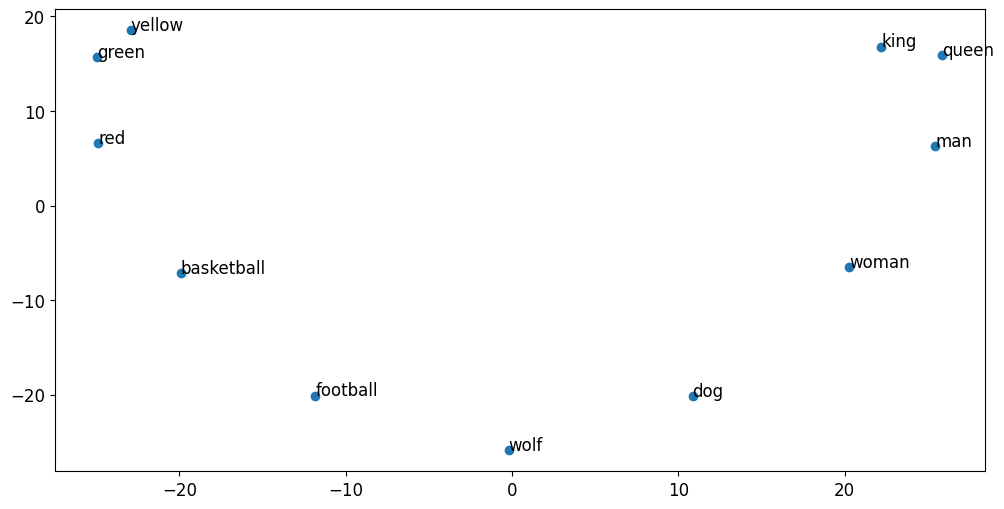

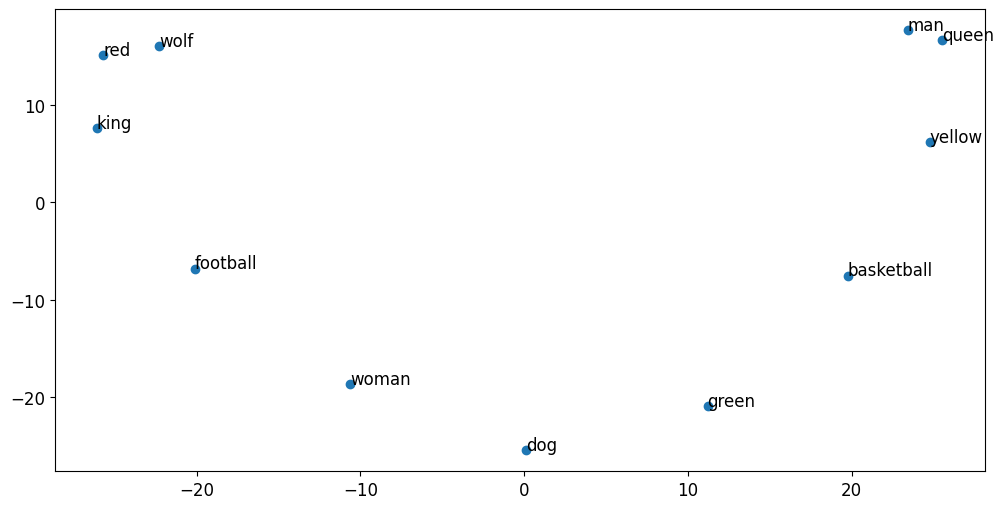

In [ ]:
W1 = 1 # Change me
W2 = 10 # Change me
embedding2 = embedding * W1 + pos_encoding[:,:,:] * W2
plot_words(embedding2, sequences, 0)
plot_words(embedding2, sequences, 1)

# For reference:
#['king queen man woman dog wolf football basketball red green yellow', 'man queen yellow basketball green dog  woman football  king red wolf']

By adjusting the weighting between semantic embeddings and positional encodings, we can directly control the influence of each on the final vector representations.

For example:
- When setting `W1 = 1` and `W2 = 10`, the positional encodings dominate. The spatial layout of the embedded words begins to follow a circular pattern — often clockwise or counter-clockwise — reflecting their relative positions in the sentence more than their semantic content.
- Reversing the weights to `W1 = 10` and `W2 = 1` gives more emphasis to the original semantic embeddings. The resulting plot closely resembles the original GloVe-based layout, with only minor distortions due to positional information.

This reflects the same strategy used in Transformer architectures, where the word embedding is scaled by the square root of the embedding dimension (i.e., `W1 = √d_model`). For an embedding size of 100, this corresponds to `W1 = 10` and `W2 = 1`.

---

### Summary

This notebook provided a hands-on look at how **semantic embeddings** and **positional encodings** interact in a Transformer model. Through a series of visualizations and exploratory steps, it became clear how relative position and meaning are blended to form input representations for the encoder and decoder.

### Key Takeaways

- **Positional encodings are designed to be smooth, periodic functions**, enabling the model to reason about token position through vector arithmetic.
- **These encodings can be linearly related**, which helps the model generalize across sequences with similar structures.
- **The relative weighting** of semantic vs. positional information determines how much emphasis is placed on meaning versus structure — this balance can greatly influence downstream model behavior.

Understanding this interaction is essential for interpreting and optimizing Transformer-based models in NLP and beyond.
